### Point density layer for 10m mosaic

Smoothing highlights the location of data gaps and areas of higher and lower uncertainty (point density)


In [1]:
# import necessary modules
import numpy as np # for array math
import rasterio # for reading and writing rasters and spatial indexing of rasters
import rasterio.plot # to plot rasters
import rasterio.features # to convert raster to shape
import gdal # to build raster stats and pyramids
from matplotlib import pyplot as plt # for colourbar maps and histogram plot
import matplotlib.colors # for colour bins in raster map
import scipy.ndimage # for focal sum
import glob # for listing files in a directory
from pathlib import Path # for handling file paths
import os # for changing the working directory
import sys  # for saving messages to file and printing in console
import logging # for saving messages to file and printing in console
import time # for start, stop time

In [2]:
# Set up logger

# Start timer
start = time.time()

# Delete old log
logfile = Path('messages.log')
if logfile.exists():
    logfile.unlink()
        
# Configure
logging.basicConfig(
    level=logging.INFO,
    format="[%(levelname)s] %(message)s",
    handlers=[logging.FileHandler("messages.log"), logging.StreamHandler()]
)
# Initiate logger
logger = logging.getLogger("")

In [3]:
# Step back to parent directory
pdir = Path().resolve().parent
os.chdir(pdir)

In [4]:
# Choose bathymetry raster to use
bathy_files = ['RCA/NNC__NONNA_10m_RCAs.tif','RCA/NCC__NONNA_10m_RCAs.tif']
# Name of output
output_files=['RCA/Smoothed_PointDenisty_NNC__NONNA_10m_RCAs.tif', 'RCA/Smoothed_PointDenisty_NCC__NONNA_10m_RCAs.tif']

In [5]:
# Smooth point density across a neighbourhood
# Using a distance weighted focal sum

# Function to smooth/interpolate the point density raster
# Size is the number of cells in the square neighbourhood (recommend choosing odd values)
def calc_smooth(size, rasters, outputs):
    # loop through raster files
    for i in range(len(rasters)):
        #  Load raster and get array and profile
        with rasterio.open(rasters[i]) as ras:
            # Message
            logger.info(('Loading bathy raster from file: ' + (rasters[i]) ))
            # Read
            array = ras.read(1)
            profile = ras.profile

        # Assign all depth values to 1 and NAs to 0
        array[array > -10000 ] = 1
        array[array < 1 ] = 0
        int_array = array.astype(int)
        int_array

        # If neighbourhood size is an even number
        if (size % 2) == 0:
            # Method for sequence when size is even
            lr = np.r_[0:1:size/2j]
            hor = np.concatenate([lr, np.flipud(lr)])
        else:
            # Method for sequence when size is odd
            hor = abs( abs(np.mgrid[-1:1:size/1j]) - 1 )
        # Weights array    
        xw,yw = np.meshgrid(hor, hor.T)
        weights = xw * yw

        # Convolution - uses 0 value at the edges
        smooth = scipy.ndimage.convolve(int_array, weights, mode='constant', cval=0)

        # Write smoothed point density array
        with rasterio.Env():
            # Update profile
            profile.update(
                dtype=rasterio.uint16,
                count=1,
                nodata=0,
                compress='lzw')
            # Write raster
            with rasterio.open(output_files[i], 'w', **profile) as dataset:
                dataset.write(smooth.astype(rasterio.uint16), 1)


# Calculate smoothed point density rasters
# Geotif output in rasters directory
calc_smooth(size=50, rasters=bathy_files, outputs=output_files)  

[INFO] Loading bathy raster from file: RCA/NNC__NONNA_10m_RCAs.tif
[INFO] Loading bathy raster from file: RCA/NCC__NONNA_10m_RCAs.tif


In [6]:
# Build pyramids and calcualte stats for all rasters
# loop through raster files
for r in output_files:
    # Set to 1 (read/write) mode to set pyramids and stats internally
    raster = gdal.Open(r, 1)
    gdal.SetConfigOption('COMPRESS_OVERVIEW', 'DEFLATE')
    # BUild pyramids for all resolutions
    raster.BuildOverviews("NEAREST", [2,4,8,16,32,64,128,256,512,1024])
    # Caluclate stats
    raster.GetRasterBand(1).GetStatistics(0,1)
    del raster

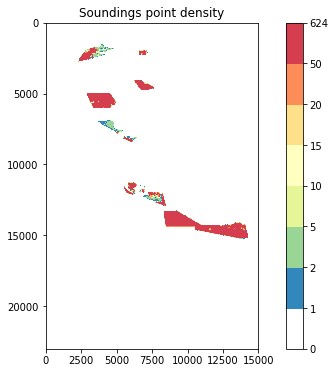

In [7]:
# Map of smoothed point densities

# Load smoothed raster
with rasterio.open(output_files[0]) as raster:
    # Read as array
    array = raster.read(1)
    # Get max value 
    maxval = array.max()
    # Set the colors
    cmap = matplotlib.colors.ListedColormap(['white','#3288bd','#99d594','#e6f598', 
                                             '#ffffbf','#fee08b','#fc8d59','#d53e4f'])
    # Define colors bins
    norm = matplotlib.colors.BoundaryNorm([0, 1, 2, 5, 10, 15, 20, 50, maxval], 8)
    # Map
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Soundings point density')
    img = ax.imshow(array, cmap=cmap, norm=norm)
    fig.colorbar(img, ax=ax);

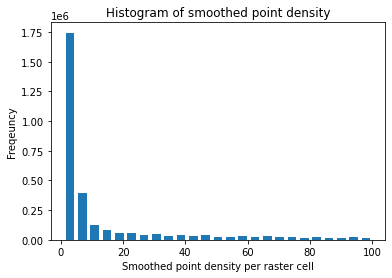

In [8]:
# Plot histogram of smoothed point density
# Between 1 and 100 point density values (not full max)

# Load smoothed raster
with rasterio.open(output_files[0]) as raster:
    # Read as array
    array = raster.read(1)
    # Calculate histogram
    hist, bins = np.histogram(array, bins=25, range=(1,100))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    # Plot
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel('Smoothed point density per raster cell')
    plt.ylabel('Freqeuncy')
    plt.title('Histogram of smoothed point density')
    plt.show()

In [9]:
# End timer
logger.info(('Total running time: ' + str(round((time.time()-start) /60)) + ' minutes'))

[INFO] Total running time: 43 minutes
